In [68]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
#Loading in data
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Checking data types for features
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [4]:
# Checking value counts for feature
df["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [5]:
# Checking value counts for feature
df["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [6]:
# Checking value counts for feature
df["sex"].value_counts()

male      676
female    662
Name: sex, dtype: int64

# Question:1 Do smokers have higher insurance charges than non-smokers?

# Null and alternate hypothesis

Null hypothesis - "Smokers and non-smokers have equal insurance charges."

Alternate hypothesis - "There is a significant difference in insurance charges for smokers compared to non-smokers."

# Test Selection
2 sample T-test

ALPHA - 0.05

In [7]:
# creating samples
sample = df.sample(n = 100,random_state = 42)
yesinschar =sample.loc[df["smoker"] == "yes", "charges"]

noinschar = sample.loc[df["smoker"] == "no", "charges"]

print(f"For smokers (n={len(yesinschar)}): Insurance charges Mean={np.mean(yesinschar):.2f}")
print(f"For non-smokers (n={len(noinschar)}): Insurance charges Mean={np.mean(noinschar):.2f}")

For smokers (n=22): Insurance charges Mean=32997.31
For non-smokers (n=78): Insurance charges Mean=8394.54


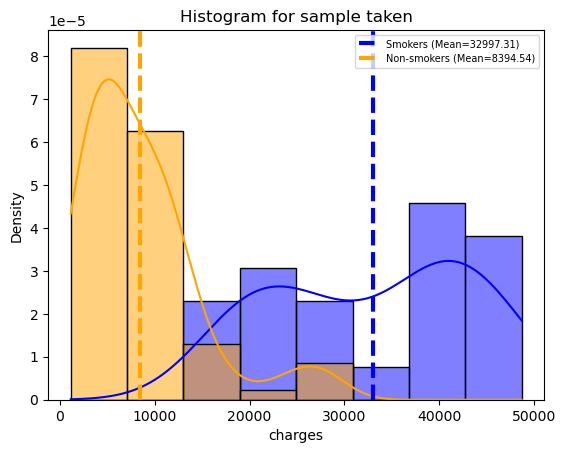

In [8]:
# visualising samples
smoker_palette = {"yes":"blue", "no":"orange"}
ax = sns.histplot(data = sample, x= "charges" , hue = "smoker", fill = True, kde = True, 
                  stat = "density", common_norm = False, palette=smoker_palette)
ax.axvline(np.mean(yesinschar), ls='--', lw=3, 
           label=f"Smokers (Mean={np.mean(yesinschar):.2f})",color=smoker_palette["yes"])
ax.axvline(np.mean(noinschar), ls='--', lw=3, 
           label=f"Non-smokers (Mean={np.mean(noinschar):.2f})",color=smoker_palette["no"])
ax.legend(prop={"size":7}, loc='upper right')
ax.set_title("Histogram for sample taken");

In [9]:
# Testing assumptions of test
# No significant outliers
# Normality 
# Equal Variance 

In [10]:
# Outliers
zscores_yes = stats.zscore(yesinschar)
outliers_yes = abs(zscores_yes)>3
np.sum(outliers_yes)

0

There are no outliers in the smoker sample

In [11]:
# outliers
zscores_no = stats.zscore(noinschar)
outliers_no = abs(zscores_no)>3
np.sum(outliers_no)

2

In [35]:
# removing outliers from non-smoker sample
noinschar = noinschar[(np.abs(stats.zscore(noinschar)) < 3)]

In [36]:
# outliers
zscores_no = stats.zscore(noinschar)
outliers_no = abs(zscores_no)>3
np.sum(outliers_no)

0

In [37]:
# Normality
result_yes = stats.normaltest(yesinschar)
print(result_yes)
result_yes.pvalue > 0.05

NormaltestResult(statistic=8.481188655372003, pvalue=0.014399031556451041)


False

In [38]:
# Normality
result_no = stats.normaltest(noinschar)
print(result_no)
result_no.pvalue > 0.05

NormaltestResult(statistic=4.011538559343466, pvalue=0.1345567441026122)


True

The smoker sample failed the normality test. This is not a normal distribution, however we have a large enough sample so we can proceed.

In [16]:
# Equal variance
result = stats.levene(yesinschar, noinschar)
print(result)
result.pvalue > 0.05

LeveneResult(statistic=28.506495620059756, pvalue=6.24829133463234e-07)


False

We do not have equal variance amongst the sample, so we will make use of equal_var = False when doing our test.

In [39]:
# Executing test
## Final t-test, after confirming we meet the assumptions
result = stats.ttest_ind(yesinschar,noinschar, equal_var = False)
result

Ttest_indResult(statistic=11.441281148432447, pvalue=5.6151366040908574e-11)

In [40]:
## is our result significant??
print(f"p-value={result.pvalue:.10f}")
print(f"Significant: {result.pvalue < 0.05}")

p-value=0.0000000001
Significant: True


# Interpreting p-value and reject or fail to reject the null hypothesis 

We have a significant result for this test. We can therefore reject our null hypothesis and conclude that there is a significant difference in insurance charges for smokers compared to non-smokers. Smokers have higher insurance charges compared to non-smokers

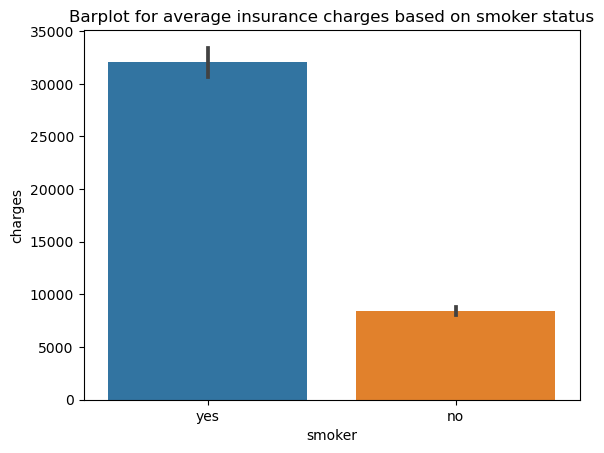

In [19]:
# Supporting visual
ax = sns.barplot(data = df, x = "smoker", y = "charges")
ax.set_title("Barplot for average insurance charges based on smoker status");

# Question:2 Are men more likely to smoke than women?

# Null and alternate hypothesis

Null hypothesis - "There is no difference in the likelihood of men who smoke, compared to woman who smoke."

Alternate hypothesis - "There is a significant difference that indicates men are more likely to smoke compared to woman."

# Test Selection
Chi-squared

ALPHA - 0.05

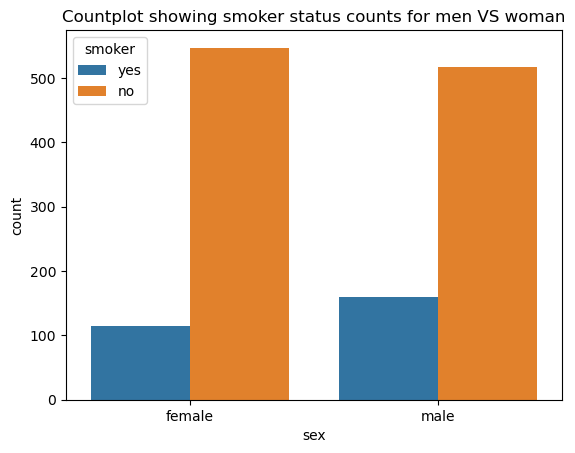

In [20]:
# Visualising the smoker status of men compared to woman.
ax = sns.countplot(data = df,x = "sex",hue = "smoker")
ax.set_title("Countplot showing smoker status counts for men VS woman");

In [21]:
# getting the crosstab
table = pd.crosstab(df["sex"],df["smoker"])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [22]:
# Testing assumptions of test
# There are two categorical variables(ordinal or nominal)
# the outcomes are independent

In [23]:
# Executing test
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [24]:
# What was our p-value?
print("P value : ",p)
p<.05

P value :  0.006548143503580696


True

# Interpreting p-value and reject or fail to reject the null hypothesis 
Our P value is less than 0.05 indicating we have a significant result, we can therefore reject our null hypothesis which is, "There is no difference in the likelihood of men who smoke, compared to woman who smoke." the test indicates that men are more likely to smoke compared to females.

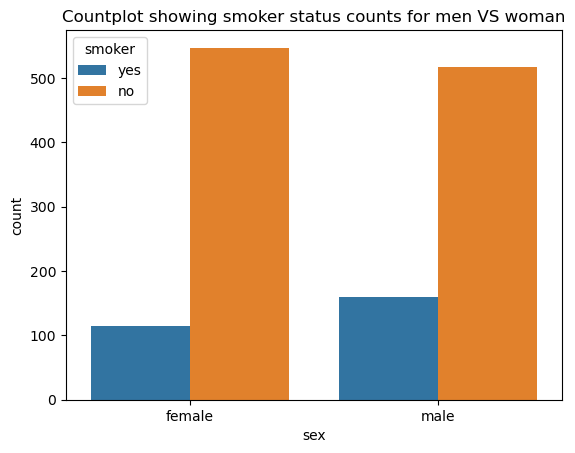

In [25]:
# Supporting visual
ax = sns.countplot(data = df,x = "sex",hue = "smoker")
ax.set_title("Countplot showing smoker status counts for men VS woman");

# Question:3 Do different regions have different charges, on average?

# Null and alternate hypothesis

Null hypothesis - "There is no difference in average charges across different regions." 

Alternate hypothesis - "There is a significant difference in average charges across different regions."

# Test Selection
ANOVA
ALPHA - 0.05

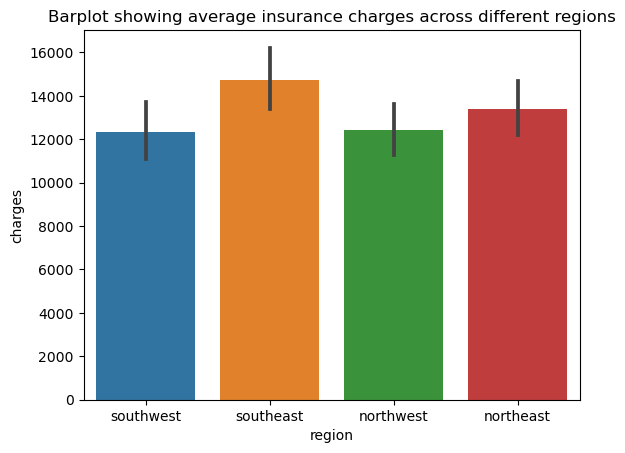

In [26]:
# visualising the average charges across different regions
ax = sns.barplot(data = df, x="region", y = "charges")
ax.set_title("Barplot showing average insurance charges across different regions");

In [27]:
# Separating regions into different groups
groups = {}
## Loop through all unique regions
for i in df["region"].unique():
    ## Get series for group and rename
    data = df.loc[df["region"]==i,"charges"].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [28]:
# Testing assumptions of test
# No significant outliers
# Equal variance
# normality

In [29]:
# normality
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [42]:
# checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < 0.05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


Every group does not have a normal distribution, however our samples are large, so we can proceed.

In [43]:
# Equal variance
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

In [44]:
# Outliers
zscores_groups = stats.zscore(data)
outliers_groups = abs(zscores_groups)>3
np.sum(outliers_groups)

4

In [64]:
# Removing outliers
data = data[(np.abs(stats.zscore(data)) < 3)]

In [65]:
# Checking for outliers again
zscores_groups = stats.zscore(data)
outliers_groups = abs(zscores_groups)>3
np.sum(outliers_groups)

0

In [73]:
# Executing test
result = stats.f_oneway( *groups.values())
print(result)
result.pvalue < 0.05

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)


True

In [74]:
# Which groups are significant?

# saving the values as charges and regions
## save the values as kg_lost and the labels to the Diet
values = df["charges"]
labels = df["region"]

In [75]:
## performing tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


# Interpreting p-value and reject or fail to reject the null hypothesis 
There is a significant difference between the south east and south west regions. We can therefore reject our null hypothesis which was: "There is no difference in average charges across different regions." The insurance charges for the southeast region are significantly higher compared to other regions.

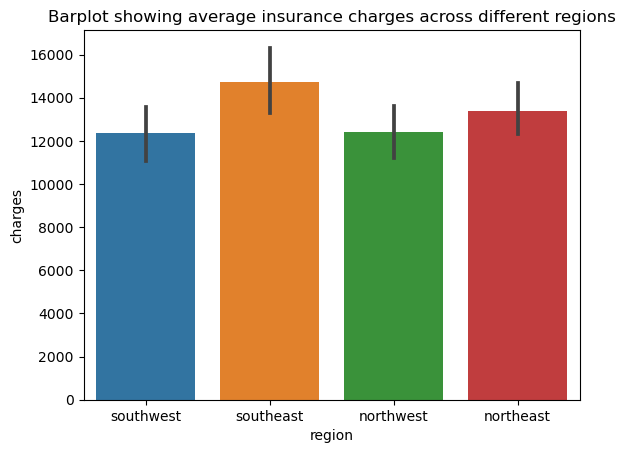

In [76]:
# Supporting visual
ax = sns.barplot(data = df, x="region", y = "charges")
ax.set_title("Barplot showing average insurance charges across different regions");